<a href="https://colab.research.google.com/github/Foster1466/Tensorflow-in-practice/blob/master/Course_4_week_2_(CW).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lesson 1** 

Creating windowed data for NN

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset= tf.data.Dataset.range(10)
for val in dataset:
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [ ]:
dataset= tf.data.Dataset.range(10)
dataset= dataset.window(5, 1, drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end= '')
  print()

01234
12345
23456
34567
45678
56789


In [ ]:
dataset= tf.data.Dataset.range(10)
dataset= dataset.window(5, shift= 1, drop_remainder=True)
dataset= dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [ ]:
dataset= tf.data.Dataset.range(10)
dataset= dataset.window(5, 1, drop_remainder=True)
dataset= dataset.flat_map(lambda window: window.batch(5))
dataset= dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [ ]:
dataset= tf.data.Dataset.range(10)
dataset= dataset.window(5,1, drop_remainder=True)
dataset= dataset.flat_map(lambda window: window.batch(5))
dataset= dataset.map(lambda window: (window[:-1], window[-1:]))
dataset= dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(), y.numpy())

[2 3 4 5] [6]
[0 1 2 3] [4]
[1 2 3 4] [5]
[5 6 7 8] [9]
[4 5 6 7] [8]
[3 4 5 6] [7]


In [ ]:
dataset= tf.data.Dataset.range(10)
dataset= dataset.window(5, 1, drop_remainder=True)
dataset= dataset.flat_map(lambda window: window.batch(5))
dataset= dataset.map(lambda window: (window[:-1], window[-1:]))
dataset= dataset.shuffle(buffer_size=10)
dataset= dataset.batch(2).prefetch(1)
for x,y in dataset:
  print('x= ', x.numpy())
  print('y= ', y.numpy())

x=  [[0 1 2 3]
 [4 5 6 7]]
y=  [[4]
 [8]]
x=  [[5 6 7 8]
 [3 4 5 6]]
y=  [[9]
 [7]]
x=  [[1 2 3 4]
 [2 3 4 5]]
y=  [[5]
 [6]]


**Lesson 2**

Training NN with a single dense layer

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time= 1000
time_train= time[:split_time]
x_train= series[:split_time]
time_valid= time[split_time:]
x_valid= series[split_time:]

window_size= 20
batch_size= 32
shuffle_buffer_size= 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset= tf.data.Dataset.from_tensor_slices(series)
  dataset= dataset.window(window_size+1, shift= 1, drop_remainder= True)
  dataset= dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset= dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset= dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset= windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0= tf.keras.layers.Dense(1, input_shape=[window_size])
model= tf.keras.Sequential([l0])

model.compile(loss= 'mse', optimizer= tf.keras.optimizers.SGD(lr= 1e-6, momentum= 0.9))
model.fit(dataset, epochs= 100, verbose= 0)

print('Layer weights {}'.format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.05495507],
       [ 0.00422079],
       [ 0.07648644],
       [-0.0336431 ],
       [-0.01026699],
       [ 0.00343667],
       [-0.02663534],
       [ 0.07320774],
       [-0.01196649],
       [ 0.00873551],
       [-0.06996187],
       [ 0.04235921],
       [-0.052915  ],
       [ 0.11549116],
       [-0.04576766],
       [ 0.02945085],
       [ 0.04157781],
       [ 0.21884249],
       [ 0.28043556],
       [ 0.40938208]], dtype=float32), array([0.01999639], dtype=float32)]


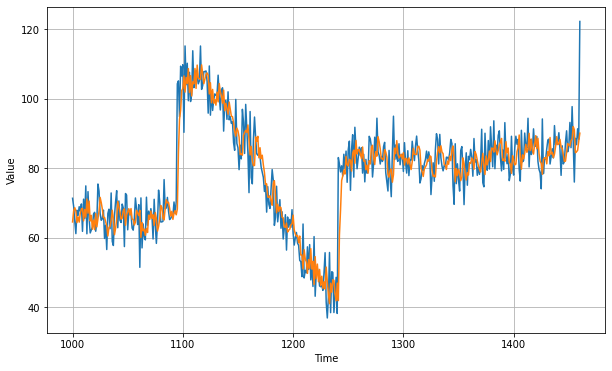

In [ ]:
forecast= []
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast= forecast[split_time-window_size:]
results= np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9369626

**Lesson 3**

Using fully connected Dense layer

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

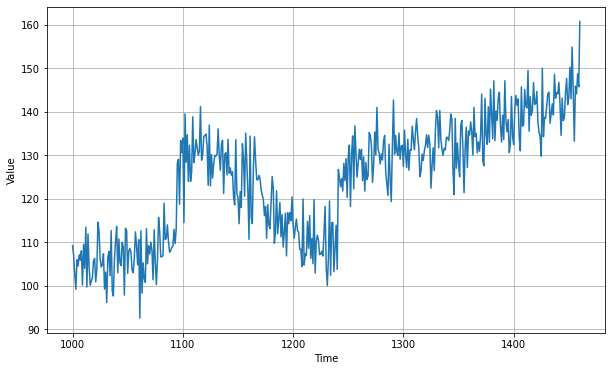

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset= tf.data.Dataset.from_tensor_slices(series)
  dataset= dataset.window(window_size+1, shift= 1, drop_remainder= True)
  dataset= dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset= dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1],window[-1]))
  dataset= dataset.batch(batch_size).prefetch(1)
  return dataset

lambda: epoch: 1e-8 * 10**(epoch/20)

epoch1: 1*10^(-8) * 10^(1/20)

epoch100: 1*10^(-8) * 10^(5)

In [ ]:
dataset= windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model= tf.keras.Sequential([
                            tf.keras.layers.Dense(10, input_shape= [window_size], activation='relu'),
                            tf.keras.layers.Dense(10, activation='relu'),
                            tf.keras.layers.Dense(1)
])

model.compile(loss= 'mse', optimizer= tf.keras.optimizers.SGD(lr= 1e-6, momentum=0.9))
model.fit(dataset, epochs= 100, verbose= 0)

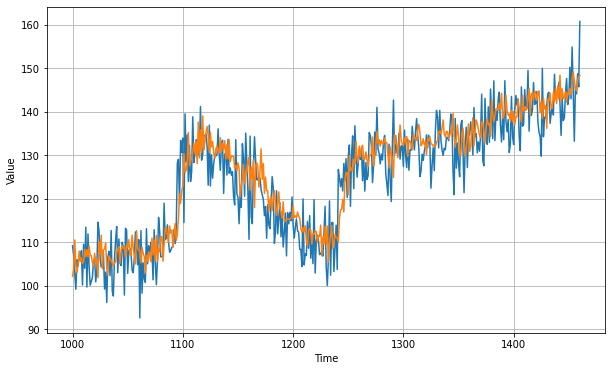

In [ ]:
forecast= []
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast= forecast[split_time-window_size:]
results= np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.846083

In [ ]:
dataset= windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model= tf.keras.Sequential([
                            tf.keras.layers.Dense(10, input_shape= [window_size], activation='relu'),
                            tf.keras.layers.Dense(10, activation='relu'),
                            tf.keras.layers.Dense(1)
])

lr_schedule= tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

optimizer= tf.keras.optimizers.SGD(lr= 1e-8, momentum=0.9)
model.compile(loss= 'mse', optimizer=optimizer)
history= model.fit(dataset, epochs= 100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

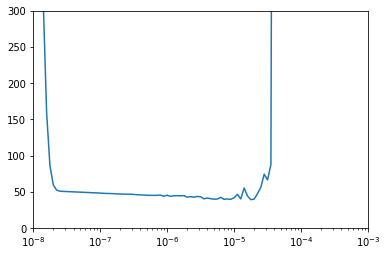

In [ ]:
lrs= 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8,1e-3,0,300])

In [ ]:
window_size= 30
dataset= windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer= tf.keras.optimizers.SGD(lr= 8e-6, momentum= 0.9)
model.compile(loss= 'mse', optimizer= optimizer)
history= model.fit(dataset, epochs=500, verbose= 0)

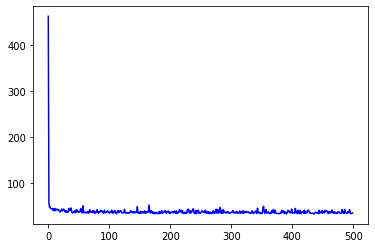

In [ ]:
loss= history.history['loss']
epochs= range(len(loss))
plt.plot(epochs, loss, 'b', label= 'Training loss')
plt.show()

[43.96018600463867, 38.705406188964844, 42.4202766418457, 40.35079574584961, 42.01555252075195, 41.86262893676758, 41.00657653808594, 41.30773162841797, 38.303741455078125, 35.96110153198242, 37.09352493286133, 38.443092346191406, 42.484649658203125, 38.42877960205078, 40.486446380615234, 42.52015686035156, 41.25812911987305, 36.72899627685547, 39.0649299621582, 35.57378005981445, 38.6317024230957, 37.367279052734375, 34.973541259765625, 38.145530700683594, 43.817623138427734, 38.948699951171875, 39.96635437011719, 45.10009765625, 40.10045623779297, 34.51670455932617, 34.81591796875, 35.05430221557617, 37.04823684692383, 38.67259216308594, 34.92532730102539, 34.914451599121094, 41.1324348449707, 36.812278747558594, 39.32371520996094, 36.13152313232422, 35.51747512817383, 35.91016387939453, 36.87781524658203, 43.66511917114258, 39.516483306884766, 34.22629928588867, 37.10359191894531, 49.51454544067383, 34.095584869384766, 35.04481887817383, 35.04356384277344, 36.25313186645508, 34.0810

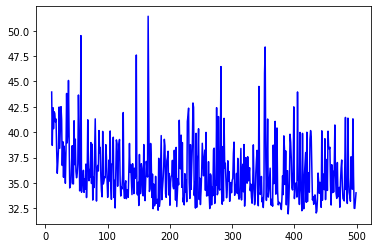

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

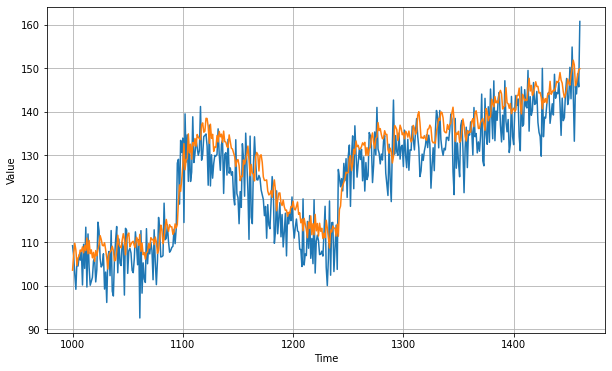

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.441237